# Image Classification with Neural Networks
## AI CA#5
## FALL 2020
### Amin Asadi

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [ ]:
X_train = pd.read_csv('./Fashion-MNIST/trainData.csv', header=None)
X_test = pd.read_csv('./Fashion-MNIST/testData.csv', header=None)
y_train = pd.read_csv('./Fashion-MNIST/trainLabels.csv', header=None)
y_test = pd.read_csv('./Fashion-MNIST/testLabels.csv', header=None)

print('number of train samples =', X_train.shape[0])
print('number of test samples =', X_test.shape[0])
print('number of features =', X_train.shape[1])

# Step One: Data Visualization and Preprocessing

## 1.1: Depicting a sample from each class of data:

In [ ]:
def show_samples(X_train, y_train):
    fig, axes = plt.subplots(1, 10, figsize=(16,7))
    for i in range(10):
        class_sample = X_train[(y_train==i)[0]].iloc[0].to_numpy()
        axes[i].set_axis_off()
        axes[i].imshow(class_sample.reshape((28,28)), cmap=plt.cm.gray_r)

show_samples(X_train, y_train)

### As we can see the images are gray-scacles which means they have only a single channel.

## 1.2: Bar plot of the class sample counts

In [ ]:
X_train['class'] = y_train
sns.countplot(x='class', data=X_train);
plt.title('count of the different classes', fontsize=16);
X_train = X_train.drop(columns='class')

### We see that all the classes has 600 samples. So the dataset is balanced.

## 1.3: Noramlizing samples:

In [ ]:
# RANGE = 255
# # X_train = X_train - X_train.mean()
# X_train = X_train / X_train

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train

# Step Two: Building a Neural Network:

# Dataloader

In [ ]:
np.random.seed(10)

In [ ]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        
        ### AMIN CHANGED THIS
        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)

    def __onehot(self, labels, n_classes):
        # TODO: Implement
        onehot_vectors = []
        for l in labels:
            binary = np.zeros((self.__n_classes, 1), dtype='int')
            binary[l] = 1
            onehot_vectors.append(binary)
        return np.array(onehot_vectors)

    def __shuffle_dataset(self):
        # TODO: Implement
        index_list = np.arange(self.__data.shape[0])
        np.random.shuffle(index_list)

        self.__data = self.__data[index_list]
        self.__onehot_labels = self.__onehot_labels[index_list]

    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

In [ ]:
# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
y_train

# Activation Functions

In [ ]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
        relu_value = np.where(matrix > 0, matrix, 0) 
        return relu_value

    def derivative(self, matrix):
        # TODO: Implement
        relu_derivative = np.where(matrix > 0, 1, 0) 
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__relu(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        # TODO: Implement
        leacky_relu_value = np.where(matrix > 0, matrix, matrix * self.negative_slope)
        return leacky_relu_value

    def derivative(self, matrix):
        # TODO: Implement
        leacky_relu_derivative = np.where(matrix > 0, 1, 0.01) 
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Tanh:

    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement
        tanh_value = 1 / (1 + np.tanh(matrix))
        return tanh_value

    def derivative(self, matrix):
        # TODO: Implement
        tanh_value = self.__val(matrix)
        sigmoid_derivative =  1 - np.power(tanh_value, 2)
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement
        sigmoid_value = 1 / (1 + np.exp(-matrix))
        return sigmoid_value

    def derivative(self, matrix):
        # TODO: Implement
        sigmoid_value = self.__val(matrix)
        sigmoid_derivative = np.multiply(sigmoid_value, (1 - sigmoid_value))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement
        exp_matrix = np.exp(matrix - np.max(matrix))
        softmax_value = exp_matrix / np.sum(exp_matrix)
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)

# Loss Function

In [ ]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        # TODO: Implement
        sm = Softmax()
        y_pred = sm(expected_val)
        cross_entropy_value = -np.sum(np.multiply(true_val, np.log(y_pred))) / len(true_val)
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        # TODO: Implement
        cross_entropy_derivative = expected_val - true_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

# Layer

In [ ]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'
        
        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight, 0) == np.size(layer_input, 1)
        # TODO: Implement
        ### START CODE HERE ###
        # W:(input_size * n_neurons)
        # X:(input_size * batch_size)
        # Z:(batch_size * n_neurons)
        self.__last_input = layer_input
        self.__last_activation_input = np.dot(layer_input, self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input) 
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)

        ### END CODE HERE ###
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative, 0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        # TODO: Implement
        ### START CODE HERE ###
        dZ = np.multiply(backprop_tensor, self.__last_activation_derivative)

        m = self.__last_input.shape[0]

        dW = np.dot(self.__last_input.T, dZ) / m
        db = np.squeeze(np.sum(dZ, axis=0)) / m

        backprop_tensor = np.dot(dZ, self.__weight.T)
        self.__weight -= lr * dW
        self.__bias -= lr * db
        ### END CODE HERE ###

        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        # TODO: Implement
        ### START CODE HERE ###
        weights = np.random.uniform(low, high, size=(dim1, dim2)) * np.sqrt(2 / dim1)
        ### END CODE HERE ###
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        # TODO: Implement
        ### START CODE HERE ###
        weights = np.random.randn(dim1, dim2) * np.sqrt(2 / (dim1))
        ### END CODE HERE ###
        return weights
    
    # def get_last_activatoin_output(self):
    #     return self.__last_activation_output
    
    @property
    def last_input(self): return self.__last_input
    

    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

In [ ]:
def rd(n):
    return round(n, 2)

# Feed Forward Neural Network

In [ ]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        ##Amin Changed THIS
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    def transform(self, network_input):
        A = network_input
        for layer in self.__layers_list:
            A = layer.forward(A)

        weights = self.__layers_list[-1].weight
        outputs = self.__layers_list[-1].last_input
        return weights, outputs
    
    # def forward(self, network_input):
    #     assert type(self.__output_shape) != None, "Model is not compiled!"
    #     # TODO: Implement
    #     A = network_input
    #     for layer in self.__layers_list:
    #         A = layer.forward(A)
    #     return A
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            if print_results: 
                print('\nEpoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_accuracy)
            if print_results:
                print('\tTrain: Average Accuracy: {}%\tAverage Loss: {}'.format(rd(average_accuracy * 100), rd(average_loss)))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\t Test: Average Accuracy: {}%\tAverage Loss: {}'.format(rd(average_accuracy * 100), rd(average_loss)))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        # TODO: Implement
        ### Start Code Here ###
        A = x_batch
        for layer in self.__layers_list:
            A = layer.forward(A)
        self.__update_weights(A, y_batch)
        batch_average_loss = self.__loss(y_batch, A)
        batch_accuracy = self.__compute_accuracy(y_batch, self.__get_labels(A))
        ### End Code Here ###
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        # TODO: Implement
        ### Start Code Here ###
        A = x_batch
        for layer in self.__layers_list:
            A = layer.forward(A)
        batch_average_loss = self.__loss(y_batch, A)

        batch_accuracy = self.__compute_accuracy(y_batch, self.__get_labels(A))
        ### End Code Here ###
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        # TODO: Implement
        ### Start Code Here ###
        # sm = Softmax()
        # outputs = sm(outputs)
        labels = np.array(list(map(lambda r : np.where(r == np.max(r), 1, 0), outputs)))
        ### End Code Here ###
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        # TODO: Implement
        ### Start Code Here ###
        accuracy = np.sum(np.all(np.equal(output, expected_output), axis=1)) /  len(output)
        ### End Code Here ###
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        # TODO: Implement
        ### Start Code Here ###
        dA = self.__loss.derivative(y_train, output)
        for layer in reversed(self.__layers_list):
            dA = layer.update_weights(dA, self.__lr)
        ### End Code Here ###
        return


## Classification

### Learning Rate Impact:
The learning rate controls the pace of changing of the parameters.

    - When lr is very high:
        + the parameters change faster and we can reach an optimum point faster(in fewer epoches)
        - The drawback is that we may reach a sub-optimum, not a global optimum.
        - We may oscillate around a minima

    - When lr is very low:
        + We will obtain convergence(to local or global minima)
        - We may get stuck in a sub-optimum point
        - The drawback is that the parameters change slower and we can reach an optimum point slowly so we we will need more epoches to converge,

In [ ]:
def FitModel(lr=0.05, batch_size=32, activation=Relu(), weight_method='uniform', n_neurons=[32, 10]):
    INPUT_SHAPE = X_train.shape[1]
    TRAINLOADER = Dataloader(X_train, y_train, 10, batch_size=batch_size, shuffle=True)
    TESTLOADER = Dataloader(X_test, y_test, 10)
    EPOCHS = 3

    network = FeedForwardNN(INPUT_SHAPE)
    network.add_layer(n_neurons[0], activation=Relu(), initial_weight=weight_method)
    network.add_layer(n_neurons[1], initial_weight=weight_method)
    network.set_training_param(loss=CrossEntropy(), lr=lr)

    log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)
    return network

In [ ]:
FitModel(lr=0.05, batch_size=32, activation=Relu(), weight_method='uniform')

In [ ]:
FitModel(lr=0.05, batch_size=32, activation=Relu(), weight_method='normal')

In [ ]:
FitModel(lr=0.005, batch_size=32, activation=Relu(), weight_method='normal')

In [ ]:
FitModel(lr=0.5, batch_size=32, activation=Relu(), weight_method='normal')

In [ ]:
FitModel(lr=0.05, batch_size=32, activation=LeakyRelu(), weight_method='uniform')

In [ ]:
FitModel(lr=0.05, batch_size=32, activation=Tanh(), weight_method='uniform')

In [ ]:
FitModel(lr=0.05, batch_size=32, activation=Sigmoid(), weight_method='uniform')

In [ ]:
FitModel(lr=0.05, batch_size=16, activation=Relu(), weight_method='uniform')

In [ ]:
FitModel(lr=0.05, batch_size=128, activation=Relu(), weight_method='uniform')

In [ ]:
network = FitModel(n_neurons=[2,10])

In [ ]:
# TRAINLOADER = Dataloader(X_train, y_train, 10)
# TESTLOADER = Dataloader(X_test, y_test, 10)

# for X_train_to_encode, _ in TRAINLOADER:
#     break

# for X_test_to_encode, y_test_to_encode in TESTLOADER:
#     break

# print(X_train_to_encode.shape, y_train_to_encode.shape)
# print(X_test_to_encode.shape, y_test_to_encode.shape)

In [ ]:
lines, X_train_2D = network.transform(X_train)
lines, X_test_2D = network.transform(X_test)
X_train_2D

In [66]:
X_train_2D_df = pd.DataFrame(X_train_2D)
X_test_2D_df = pd.DataFrame(X_test_2D)

In [68]:
X_train_2D_df['class'] = pd.DataFrame(y_train)
X_test_2D_df['class'] = pd.DataFrame(y_test)

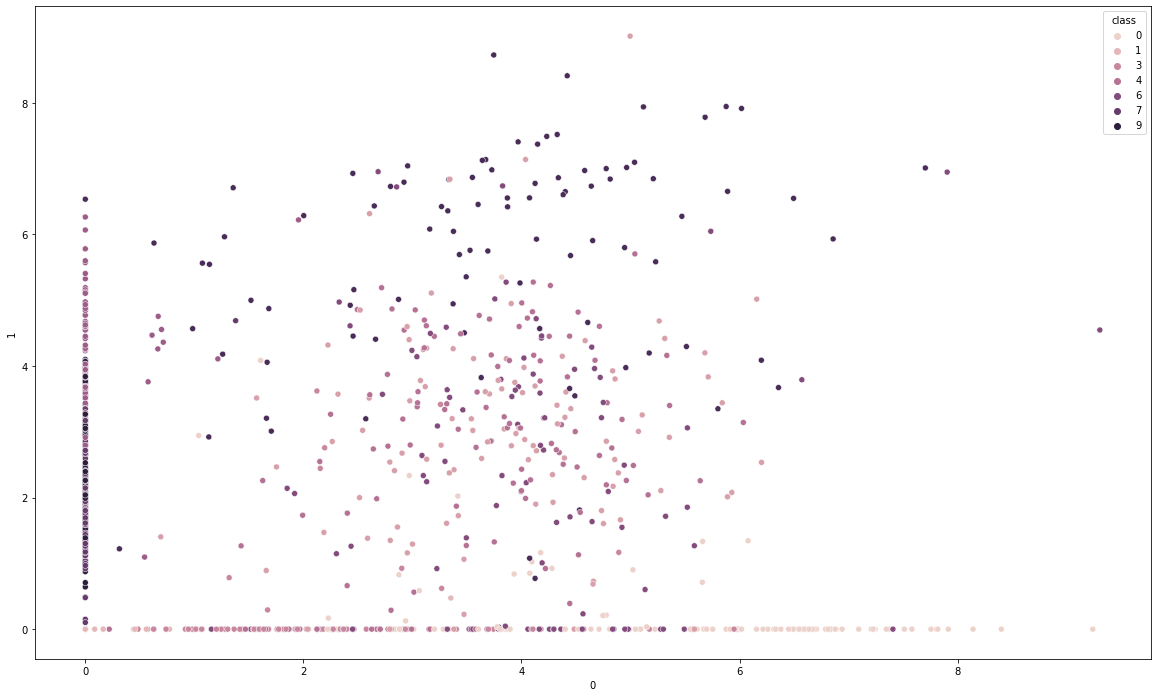

In [78]:
plt.figure(figsize=(20,12))
sns.scatterplot(data=X_test_2D_df[:1000], x=0, y=1, hue="class")

In [76]:
lines.shape

(2, 10)

In [ ]:
weights.shape

In [ ]:
plt.figure(figsize=(20,12))
plt.scatter(encoded_state[:,0], encoded_state[:,1])